In [1]:
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import tensorflow as tf
from functools import reduce

%matplotlib inline

GLOBAL_SEED=1
VERBOSITY=1
TESTING=0

np.random.seed(GLOBAL_SEED)

In [2]:
# useful function for recovering functions in deleted cells
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

In [3]:
# wrapper around tf.get_variable that checks if the variable has already been defined.
# useful for playing around in jupyter. allows you to call cells multiple times
def get_variable_wrap(*args, **kwargs):
    try:
        return tf.get_variable(*args, **kwargs)
    except ValueError:
        tf.get_variable_scope().reuse_variables()
        return tf.get_variable(*args, **kwargs)

## do matrix multiplication with weights and add bias (as in fully connected layer)
def fc_act(x, next_layer_size, act=None):
    prev_layer_size = x.get_shape()[1]
    w = get_variable_wrap("weights", [prev_layer_size, next_layer_size], initializer=tf.random_normal_initializer())
    b = get_variable_wrap("bias", [next_layer_size], initializer=tf.constant_initializer(0.0))
    o = tf.add(tf.matmul(x, w), b)
    if act: return act(o)
    else: return o

# Sample Data
I want to create 100 bi-variate time-series sampled from the same distribution and split them into train/validation/test 70/20/10, i.e. split into groups of time-series size 14/4/2.

In [4]:
def gen_time_series(n_points):
    time_series = np.array([[np.random.normal(mu*i, sigma*i), 
                        np.random.normal(mu*i, sigma*i/4)] 
                       for i in range(n_points)])
    return time_series

(70, 100, 2)
14000 data values


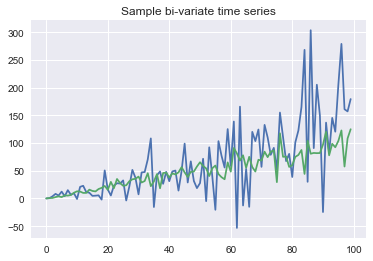

In [5]:
mu=1
sigma=1
n_series=70
n_points = 100
n_features = 2
# multi-variate time-series: 
# x_t ~ [Gaussian(mu*t,sigma*t), Gaussian(mu*t,sigma*t/4)]
# Points X Time X Features
x_data = np.zeros((n_series,n_points,n_features))
for i in range(n_series):
    x_data[i] = gen_time_series(n_points)

if TESTING: x_data_test=x_data[:10]
plt.title("Sample bi-variate time series")
for i in range(n_features):
    plt.plot(x_data[0,:,i]);
print(x_data.shape)
print(reduce(lambda x,y: x*y, list(x_data.shape)), "data values")

# Settings for VRNN

In [6]:
# test computing latent variable
batch_size=10

rnn_size=20
x_size=x_data.shape[1]
x_1_size=x_data.shape[1]

z_size=15
z_1_size=15

phi_size = 25   # N ~ q(z|x)
prior_size = 25 # N ~ p(z)
theta_size = 25 # N ~ p(x|z)

#get shape
x_t_shape = list(x_data.shape)
nbatches=max(x_t_shape[0]//batch_size,1)
x_t_shape[0] = int(max(x_t_shape[0]/nbatches,1))
print("nbatches", nbatches)
print("input shape", x_t_shape)
# input
x_t = tf.placeholder(tf.float32, shape=x_t_shape, name="x_t")

nbatches 7
input shape [10, 100, 2]


# Building Variational RNN

note that all gaussian distribtutions: p(z), q(z|x), p(x|z) should have the same dimensionality, i.e. share z_size

## LSTM Cell

In [7]:
def init_lstm_cell(rnn_size, batch_size):
    with tf.variable_scope("lstm"):
        try:
            cell = tf.contrib.rnn.LSTMCell(rnn_size, state_is_tuple=True)
        except:
            cell = tf.contrib.rnn.LSTMCell(rnn_size, state_is_tuple=True, reuse=True)
        # get initial_state of rnn
        state = cell.zero_state(batch_size, tf.float32)
    return cell, state

# cell, state = init_lstm_cell(rnn_size, batch_size)

## Encoder/Inference

In [8]:
def get_encoding(x_t, rnn_hidden, x_1_size, phi_size, z_size):
    with tf.variable_scope("encoder"):
        with tf.variable_scope("x_1"):
            x_1 = fc_act(x_t, x_1_size, act=tf.nn.relu)
        with tf.variable_scope("phi"):
            phi = fc_act(tf.concat([x_1, rnn_hidden], axis=1), z_size, act=tf.nn.relu)
        with tf.variable_scope("phi_mu"):
            phi_mu = fc_act(phi, z_size)
        with tf.variable_scope("phi_sigma"):
            phi_sigma = fc_act(phi, z_size, act=tf.nn.softplus)
    epsilon = tf.random_normal(shape=[x_t.get_shape().as_list()[0], z_size], seed=GLOBAL_SEED)
    # z = mu + epsilon*sigma
    z_t = tf.add(phi_mu, tf.multiply(epsilon, phi_sigma))
    return [x_1, 
            phi,
            phi_mu,
            phi_sigma,
            z_t]


## Prior

In [9]:
def get_prior(rnn_hidden, prior_size, z_size):
    with tf.variable_scope("prior"):
        with tf.variable_scope("prior"):
            prior = fc_act(rnn_hidden, prior_size, act=tf.nn.relu)
        with tf.variable_scope("prior_mu"):
            prior_mu = fc_act(prior, z_size)
        with tf.variable_scope("prior_sigma"):
            prior_sigma = fc_act(prior, z_size, act=tf.nn.softplus)
    return [prior, 
            prior_mu, 
            prior_sigma]


## Decoder/Generation

In [10]:
def get_decoding(z_t, rnn_hidden, z_1_size, theta_size, x_size):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("z_1"):
            z_1 = fc_act(z_t, z_1_size, act=tf.nn.relu)
        with tf.variable_scope("theta"):
            theta = fc_act(tf.concat([z_1, rnn_hidden],axis=1), theta_size, act=tf.nn.relu)
        with tf.variable_scope("theta_mu"):
            theta_mu = fc_act(theta, x_size)
        with tf.variable_scope("theta_sigma"):
            theta_sigma = fc_act(theta, x_size, act=tf.nn.softplus)
    return [z_1,
            theta,
            theta_mu,
            theta_sigma]


## vrnn recurrence

In [11]:
def vrnn_recurrence(rnn_cell, x_1, z_1, state):
    try:
        return rnn_cell(tf.concat([x_1, z_1], axis=1), state, "rnn")
    except:
        tf.get_variable_scope().reuse_variables()
        return rnn_cell(tf.concat([x_1, z_1], axis=1), state, "rnn")


## calculate values for objective function and define optimization op

In [12]:
PI=np.pi
def negative_log_likelihood_gaussian(y, mu, sigma):
    """
                a                  b              c
    (1/2)*[ ((y-mu)/sigma)^2 + 2*log(sigma) + log(2*pi) ]
    learn more: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood
    """
#     sigma might be really small. in that case, a & b blow up
    sigma=tf.clip_by_value(sigma, 1e-3,1e10)
    a = tf.square(tf.div(tf.subtract(y,mu), sigma))
    b = 2*tf.log(sigma)
    c = tf.log(2*PI)
    return tf.add(tf.add(a,b),c)

def kl_gaussian_gaussian(mu1, sigma1, mu2, sigma2):
    """
            a                  b         c           d
    log(sigma2/sigma1) + (sigma1^2 + (mu1-mu2)^2)/2sigma2^2 - 1/2
    """
    # Note: if sigma1 or sigma2 go to 0, this explodes
    sigma1=tf.clip_by_value(sigma1, 1e-3,1e10)
    sigma2=tf.clip_by_value(sigma2,1e-3,1e10)
    a = tf.log(sigma2/sigma1)
    b = tf.square(sigma1)
    c = tf.square(tf.subtract(mu1,mu2))
    d = 2*tf.square(sigma2)
    e = tf.divide(tf.add(b,c), d)
    return tf.add(a,e) - 0.5


In [13]:
# variable scope used as per: http://stackoverflow.com/questions/43183850/tensorflow-valueerror-variable-does-not-exist-or-was-not-created-with-tf-get-v
def get_optimizer(objective_function):
    train_op = tf.train.AdamOptimizer()
    try:
        return train_op.minimize(tf.reduce_mean(objective_function))
    except ValueError:
        with tf.variable_scope(tf.get_variable_scope(),reuse=False): 
            return train_op.minimize(tf.reduce_mean(objective_function))

## class for vrnn

In [14]:
class VRNN(object):
    """docstring for VRNN"""
    def __init__(self, x_t, batch_size, rnn_size, x_size, x_1_size, 
               z_size, z_1_size, phi_size, prior_size, theta_size):
        self.x_t = x_t # place holder for time-series
        self.batch_size = batch_size
        self.rnn_size = rnn_size
        self.x_size = x_size
        self.x_1_size = x_1_size
        self.z_size = z_size
        self.z_1_size = z_1_size
        self.phi_size = phi_size
        self.prior_size = prior_size
        self.theta_size = theta_size
        
        self.cell, self.state = init_lstm_cell(rnn_size, batch_size)
        print ("cell", self.cell)
        print ("state", self.state)
        self._build()

    def reset_cell(self): 
        self.state = self.cell.zero_state(self.batch_size, tf.float32)
    
    def _vrnn_step(self, vals, x_t):
        # get latest values
        # I chose to store them all but you don't HAVE to do this. 
        # This is a convenient thing to do however so you can check values later on
        cell_state = vals[0]

        prev_hidden = vals[1]
        # mu_z, sigma_z = f(x, ht-1)
        encoding_vals = [x_1, 
                phi,
                phi_mu,
                phi_sigma,
                z_t] = \
                    get_encoding(x_t, prev_hidden, self.x_1_size, self.phi_size, self.z_size)

        # mu_phi, sigma_phi = f(ht-1)
        prior_vals = [prior, 
                prior_mu, 
                prior_sigma] = \
                    get_prior(prev_hidden, self.prior_size, self.z_size)

        # mu_x , sigma_x = f(z, ht-1)
        decoding_vals = [z_1,
                theta,
                theta_mu,
                theta_sigma] = \
                    get_decoding(z_t, prev_hidden, self.z_1_size, self.theta_size, self.x_size)

        cell_output, cell_state = vrnn_recurrence(self.cell, x_1, z_1, state)

        return (cell_state[0],
                cell_state[1],
                cell_output
#                 x_1,
#                 phi,
#                 phi_mu,
#                 phi_sigma,
#                 prior,
#                 prior_mu,
#                 prior_sigma,
#                 z_t,
#                 z_1,
#                 theta,
#                 theta_mu,
#                 theta_sigma
               )
    def _build(self):
        self.output = self._scan_sequence(tf.transpose(self.x_t, [1, 0, 2]))
        self.nll = negative_log_likelihood_gaussian(self.x_t, output[-2], output[-1])
        self.klgg = kl_gaussian_gaussian(output[4], output[5], 
                                    output[7], output[8])
        self.objective = tf.add(tf.reduce_mean(nll),tf.reduce_mean(klgg))
        self.train_op = get_optimizer(self.objective)
    
    def _scan_sequence(self, sequence):
        return tf.scan(self._vrnn_step, sequence, initializer=(
                self.state[0], # cell_state - 0,
                self.state[1] # hidden_state - 1,
#                 tf.Variable(np.zeros((self.batch_size, rnn_size))) # cell_output - 2
#                 tf.Variable(np.zeros((self.batch_size, x_size))), # x_1 - 3
#                 tf.Variable(np.zeros((self.batch_size, phi_size))), # phi - 4
#                 tf.Variable(np.zeros((self.batch_size, phi_size))), # phi_mu - 5
#                 tf.Variable(np.zeros((self.batch_size, phi_size))), # phi_sigma - 6
#                 tf.Variable(np.zeros((self.batch_size, prior_size))), # prior - 7
#                 tf.Variable(np.zeros((self.batch_size, prior_size))), # prior_mu - 8
#                 tf.Variable(np.zeros((self.batch_size, prior_size))), # prior_sigma - 9
#                 tf.Variable(np.zeros((self.batch_size, z_size))), # z_t - 10
#                 tf.Variable(np.zeros((self.batch_size, z_size))), # z_1 - 11
#                 tf.Variable(np.zeros((self.batch_size, theta_size))), # theta - 12
#                 tf.Variable(np.zeros((self.batch_size, theta_size))), # theta_mu - 13
#                 tf.Variable(np.zeros((self.batch_size, theta_size))) # theta_sigma - 14
        ))
    
    @property
    def reconstructions(self):
        return self.output[10], self.output[11]
    
    @property
    def cell_states(self):
        return self.output[0]

    @property
    def cell_outputs(self):
        return self.output[1]

    @property
    def inferences(self):
        return self.output[3], self.output[4]

    @property
    def loss(self):
        return self.objective
    
vrnn = VRNN(x_t, batch_size, rnn_size, x_size, x_1_size, 
       z_size, z_1_size, phi_size, prior_size, theta_size)    

cell <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x12d6670b8>
state LSTMStateTuple(c=<tf.Tensor 'lstm/LSTMCellZeroState/zeros:0' shape=(10, 20) dtype=float32>, h=<tf.Tensor 'lstm/LSTMCellZeroState/zeros_1:0' shape=(10, 20) dtype=float32>)


NameError: name 'state' is not defined

# Train model

In [17]:
NEPOCH = 1
nbatches=max(x_t_shape[0]//batch_size,1)

loss = np.zeros(NEPOCH) # store the training progress here.

# saver = tf.train.Saver()
# sess = tf.InteractiveSession()
# sess.run(tf.global_variables_initializer())
# nbatches=1
# for i in range(NEPOCH):
#     for j in range(nbatches):
#         sess.run(vrnn.get_train_op(), 
#                  feed_dict={x_t: x_data[j*10:(j+1)*10]})
# #             nll, klgg = sess.run([vrnn_vals["nll"], vrnn_vals["klgg"]], 
# #                      feed_dict={vrnn_vals["x_t"]: x_data[j*10:(j+1)*10]})
# #             loss[i] += (nll.mean()+klgg.mean())/batch_size

# # save_path = saver.save(sess, "/tmp/vrnn_1000.ckpt")
# plt.plot(loss);
# print (loss[-1])

In [16]:
# functions to train model and plot results
def run_model(NEPOCH, vrnn_vals, x_data):
    loss = np.zeros(NEPOCH)
    for i in range(NEPOCH):
        for j in range(x_data.shape[0]//batch_size):
            sess.run(vrnn_vals["train_op"], 
                     feed_dict={vrnn_vals["x_t"]: x_data[j*10:(j+1)*10]})
            nll, klgg = sess.run([vrnn_vals["nll"], vrnn_vals["klgg"]], 
                     feed_dict={vrnn_vals["x_t"]: x_data[j*10:(j+1)*10]})
            loss[i] += (nll.mean()+klgg.mean())/batch_size
    return loss

def plot_results(x_data, vrnn_vals, indx):
    reconstruction=np.zeros((x_data.shape))
    for j in range(x_data.shape[0]//batch_size):
            mu, sigma = sess.run([vrnn_vals["theta_mu"], vrnn_vals["theta_sigma"]], 
                     feed_dict={vrnn_vals["x_t"]: x_data[j*10:(j+1)*10]})
            reconstruction[j*10:(j+1)*10] = np.random.normal(mu, sigma)
    plt.title("After 1000 epochs")
    plt.plot(x_data[:,indx], label="original");
    plt.plot(reconstruction[:,indx], label="reconstruction");
    plt.legend()

In [18]:
NEPOCH = 1
nbatches=max(x_t_shape[0]//batch_size,1)

loss = np.zeros(NEPOCH) # store the training progress here.
vrnn_vals = build_vrnn(batch_size, rnn_size, x_size, x_1_size, 
           z_size, z_1_size, phi_size, prior_size, theta_size)


saver = tf.train.Saver()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
nbatches=1
for i in range(NEPOCH):
    for j in range(nbatches):
        sess.run(vrnn_vals["train_op"], 
                 feed_dict={vrnn_vals["x_t"]: x_data[j*10:(j+1)*10]})
#             nll, klgg = sess.run([vrnn_vals["nll"], vrnn_vals["klgg"]], 
#                      feed_dict={vrnn_vals["x_t"]: x_data[j*10:(j+1)*10]})
#             loss[i] += (nll.mean()+klgg.mean())/batch_size

# save_path = saver.save(sess, "/tmp/vrnn_1000.ckpt")
plt.plot(loss);
print (loss[-1])

ValueError: Cannot feed value of shape (1, 100, 2) for Tensor 'x_t_1:0', which has shape '(10, 100)'

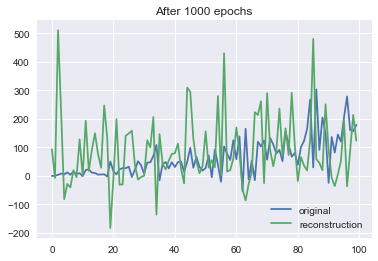

In [95]:
reconstruction=np.zeros((x_data.shape))
for j in range(x_data.shape[0]//batch_size):
        mu, sigma = sess.run([vrnn_vals["theta_mu"], vrnn_vals["theta_sigma"]], 
                 feed_dict={vrnn_vals["x_t"]: x_data[j*10:(j+1)*10]})
#         print (np.random.normal(mu, sigma))
        reconstruction[j*10:(j+1)*10] = np.random.normal(mu, sigma)
plt.title("After 1000 epochs")
plt.plot(x_data[:,0], label="original");
plt.plot(reconstruction[:,0], label="reconstruction");
plt.legend()

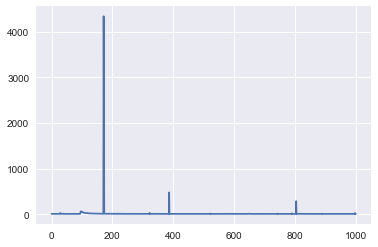

In [98]:
loss = run_model(1000, vrnn_vals, x_data)
plt.plot(loss);

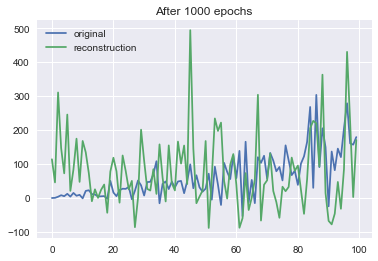

In [101]:
plot_results(x_data, vrnn_vals)

7.03561348915


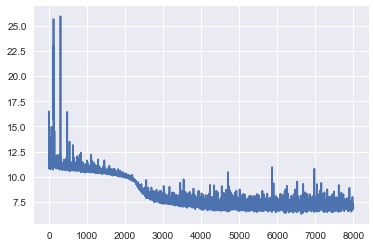

In [106]:
loss = run_model(8000, vrnn_vals, x_data)
plt.plot(loss);
print(loss[-1])

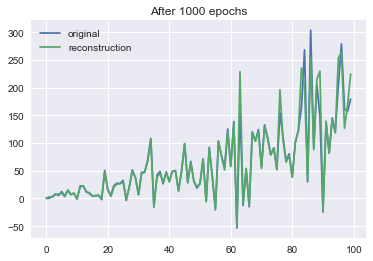

In [108]:
plot_results(x_data, vrnn_vals)
# officially overfit

## Resources
another link to useful tensorflow example but with RNN
1. [Useful example](https://rdipietro.github.io/tensorflow-scan-examples/#some-final-thoughts) for using scan with a vanilla RNN

# Thrown out

In [ ]:
# old vrnn_call
def vrnn_call(x_t, rnn_cell, z_size, 
              x_1_size, z_1_size, phi_size, theta_size, vals):
    state=vals["state"]
    encoding_vals = \
                get_encoding(x_t, state[1], x_1_size, phi_size, z_size)
    vals.update(encoding_vals)

    prior_vals = \
                get_prior(state[1], prior_size, z_size)
    vals.update(prior_vals)   

    decoding_vals = \
                get_decoding(vals["z_t"], state[1], z_1_size, theta_size, x_size)
    vals.update(decoding_vals)

    output, state = vrnn_recurrence(rnn_cell, vals["x_1"], vals["z_1"], state)
    vals["state"] = state
    vals["output"] = output 
# testing function 
if TESTING:
    vals={"state": state}
    vrnn_call(x_t, cell, z_size, 
                  x_1_size, z_1_size, phi_size, theta_size, vals)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    o = sess.run([vals["state"]], feed_dict={x_t:x_data_test})
#     print(o)
    sess.close()